Imports and setup

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#defining paths
RAW = "../data/raw/"
INTERIM = "../data/interim/"
PROCESSED = "../data/processed/"

pd.set_option("display.max_columns", 50)

Initial data loading and checks

In [29]:
orders = pd.read_csv("../data/raw/olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
#orders.head()
order_items = pd.read_csv("../data/raw/olist_order_items_dataset.csv")
#order_items.head()
#orders.dtypes
#order_items.dtypes

In [30]:
print(orders["order_purchase_timestamp"].agg(["min", "max"]))

print(orders["order_status"].value_counts(dropna=False))

# Range of orders runs from 2016 to 2018 like mentioned in the Kaggle webpage. 
# Most of the orders are marked as delivered with some marked as "shipped", "canceled", "unavailable", "invoiced", "processing", "created", and "approved".
# For modeling demand and pricing behavior, I'll only use "delivered" orders since they are completed sales.

min   2016-09-04 21:15:19
max   2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: datetime64[ns]
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


In [32]:
print(orders[["order_id","order_purchase_timestamp","order_status"]].isna().sum())
print(order_items[["order_id","product_id","price","freight_value"]].isna().sum())

# No missing values in the main columns so need not worry about having to drop rows or imputation later

order_id                    0
order_purchase_timestamp    0
order_status                0
dtype: int64
order_id         0
product_id       0
price            0
freight_value    0
dtype: int64


### Filtering and creating the base dataset

I'm filtering out everything except "delivered" orders to make sure I'm only working with completed sales since those are the ones that accurately reflect custmer demand.

In [35]:
# filter for delivered orders
orders_delivered = orders[orders["order_status"]=="delivered"].copy()

# merging order with order items
order_items_merged = pd.merge(order_items, orders_delivered[["order_id", "order_purchase_timestamp"]], on="order_id", how="inner")

#just to check what dataset looks like now
print(order_items_merged.shape)

# saving it
order_items_merged.to_csv("../data/interim/orders_items_clean.csv", index=False)

order_items_merged.head()

(110197, 8)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51


The merged file now has ~110k ros where each row represents one actual item sold (and delivered). This includes product ID, its price, freight cost, seller, and timestamp of when the order was placed. This will be the basic dataset I'll have to build everything else on.

### Basic EDA

Just to get a feel for the data and try and find any high level patterns, num of unique products/sellers, etc. Also helps confirm whether the dataset is well distributed and not just dominated by one or two sellers.

In [37]:
# quick high level stats
n_orders = order_items_merged["order_id"].nunique()
n_products = order_items_merged["product_id"].nunique()
n_sellers = order_items_merged["seller_id"].nunique()

avg_price = order_items_merged["price"].mean()
avg_freight = order_items_merged["freight_value"].mean()

summary = {
    "Unique Orders": n_orders,
    "Unique Products": n_products,
    "Unique Sellers": n_sellers,
    "Average Price": round(avg_price, 2),
    "Average Freight": round(avg_freight, 2)
}

summary

{'Unique Orders': 96478,
 'Unique Products': 32216,
 'Unique Sellers': 2970,
 'Average Price': np.float64(119.98),
 'Average Freight': np.float64(19.95)}

Observations from markdown above:
1) around 96k real orders placed by customers (same number as "delivered" orders so we can be confident that my merge worked properly and nothing we needed was dropped)
2) over 32k unique products across around 3k sellers - this gives us enough variety to study price diffs by product or category
3) avg price gives quick sense of scale but could be skewed by a few high prices products so can look at median and distribution to get a better picture.

Overall, this looks like a solid base dataset to start exploring patterns like pricing trends and demand over different time periods

Median Price: 74.90
Median Freight: 16.26


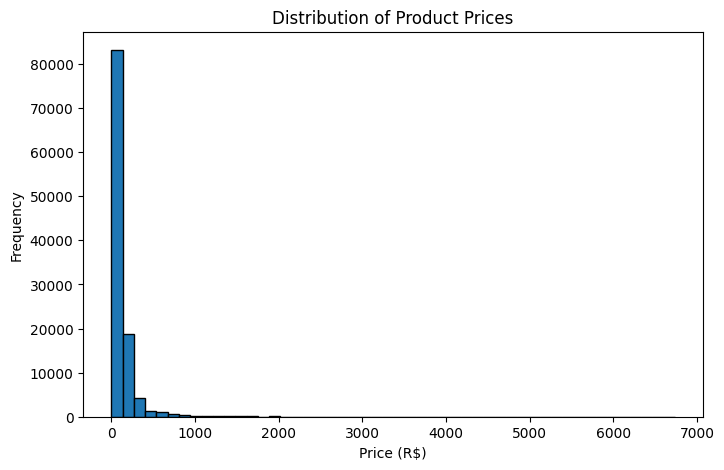

In [39]:
# Price distribution of the products

median_price = order_items_merged["price"].median()
median_freight = order_items_merged["freight_value"].median()

print(f"Median Price: {median_price:.2f}")
print(f"Median Freight: {median_freight:.2f}")

plt.figure(figsize=(8,5))
plt.hist(order_items_merged["price"], bins=50, edgecolor='k')
plt.title("Distribution of Product Prices")
plt.xlabel("Price (R$)")
plt.ylabel("Frequency")
plt.show()


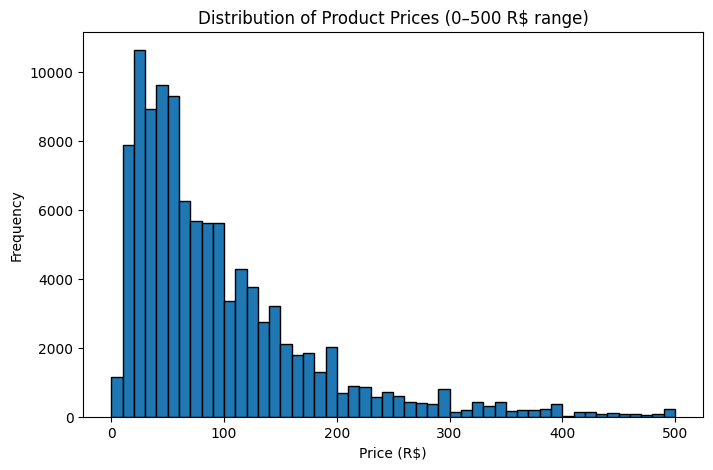

In [41]:
# Just zoomed in to see a more detailed breakdown of the cheaper items which arent visible in the plot above 
plt.figure(figsize=(8,5))
plt.hist(order_items_merged["price"], bins=50, range=(0,500), edgecolor='k')
plt.title("Distribution of Product Prices (0–500 R$ range)")
plt.xlabel("Price (R$)")
plt.ylabel("Frequency")
plt.show()


### Interpretation
Most products fall in a lower price range with only a few expensive items priced in the thousands. This makes sense for an ecommerce dataset (Higher end products may be electronics? Can look into more product category details later)

What this means for a dynamic pricing model- 
1) Can't apply the same pricing strategy to all SKUs 
2) Mean prices arent reliable so we need to use category specific percentiles to be more accurate -> possibly have to do a log transform on price data??

In [43]:
# The product category names are in portuguese in the original products file so use the translation file provided to 
#convert to English names

# read the products file
products = pd.read_csv("../data/raw/olist_products_dataset.csv")

# read translation file
translation = pd.read_csv("../data/raw/product_category_name_translation.csv")

# merge with products
products = pd.merge(products, translation, on="product_category_name", how="left")

# rename for clarity
products.rename(columns={"product_category_name_english": "category_name_en"}, inplace=True)

#merging this version with the main base dataset i created earlier
merged_with_category = order_items_merged.merge(products[["product_id", "category_name_en"]], on="product_id", how="left")

merged_with_category.head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,category_name_en
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,garden_tools


In [45]:
# Getting more category specific stats/breakdown

# group by category and get summary stats
category_price_summary = (
    merged_with_category.groupby("category_name_en")["price"]
    .agg(["count", "mean", "median", "std"])
    .sort_values("mean", ascending=False)
)

category_price_summary.head(10)

,count,mean,median,std
category_name_en,,,,
computers,199,1098.915276,1100.00,672.496840
small_appliances_home_oven_and_coffee,73,638.213151,640.99,616.895620
home_appliances_2,231,467.333117,227.99,530.601492
agro_industry_and_commerce,206,342.553883,243.75,424.010065
musical_instruments,651,283.127097,94.90,446.411304
small_appliances,658,277.741824,98.36,476.525999
fixed_telephony,255,216.922392,49.00,419.719367
construction_tools_safety,183,211.875519,115.00,327.121069
watches_gifts,5859,199.040276,128.99,253.798436


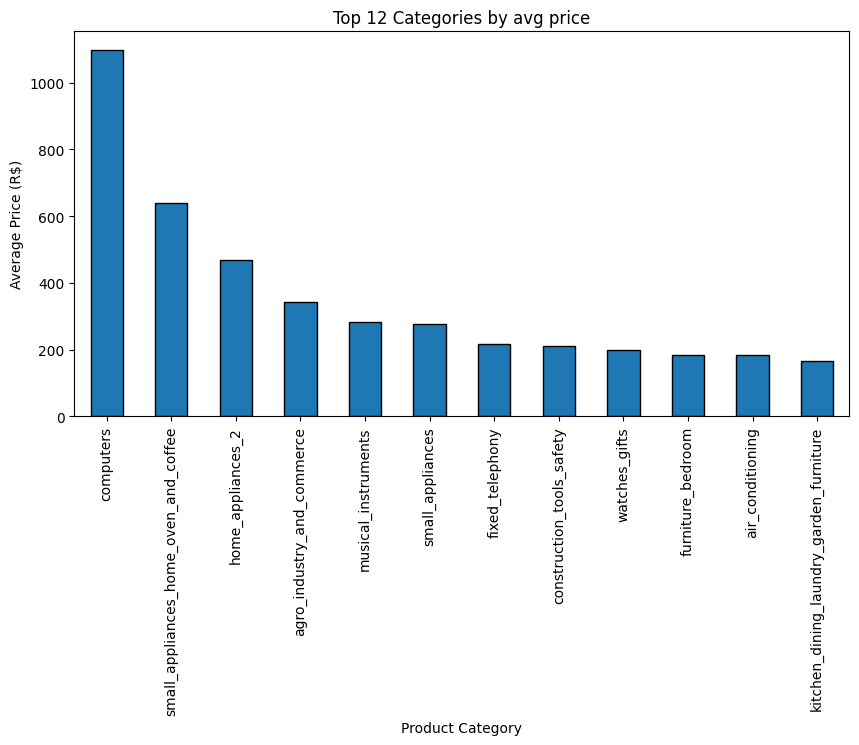

In [48]:
# Visualizing top categories by avg price

topN = 12
top_categories = (
    merged_with_category.groupby("category_name_en")["price"]
    .mean()
    .sort_values(ascending=False)
    .head(topN)
)

ax = top_categories.plot(kind="bar", figsize=(10,5), edgecolor="k")
ax.set_title(f"Top {topN} Categories by avg price")
ax.set_ylabel("Average Price (R$)")
ax.set_xlabel("Product Category")
ax.tick_params(axis="x", rotation=90)

### Observations

1) Some category names seem redundant. "small_appliances_home_oven_and_coffee" and "small_appliances", "home_appliances_2" implies a "home_appliances_1"??.

These may be because of inconsistent translations from the file provided or just sub splits of the same product lines. Somethnig to keep in mind when doing actual modeling work. Maybe standardize category labels to make it cleaner??

## Possible approach

Based on what I’ve explored so far, the next step is to figure out how this data could feed into an actual pricing model.

### 1. Goal
Build a model that learns how demand changes with price and helps set optimal prices that balance sales volume and profit. So basically, the system adapts to what’s been happening in the market.

### 2. Data I'm relying on
For now, I’m working with what’s already in the Olist dataset(past transaction info like price, freight, order timing, and product category). To make it more realistic, I'm also planning on adding holiday dates to capture seasonality

Maybe down the line, a full setup could also pull in
1. Inventory data from internal systems (to make the model stock-aware)
2. Competitor pricing from APIs or scraping tools

Might be tough to get this data but for a production level system, we would have access to inventory details and could pay for competitor price scraper services?

### 3. Next steps
1. Aggregate by product and time- see how demand (quantity sold) moves with price changes
2. Estimate price elasticity for different product categories. Basically, find out how sensitive buyers are to small price changes
3. Model demand using something simple first (like linear or tree based regression) before experimenting with time based or reinforcement learning approaches (if RL not overkill here)
4. Simulate outcomes- predict revenue/profit across different price points and identify what works best

### 4. Why this approach
It’s structured enough to give measurable insights (like elasticity and trend shifts) but still flexible for scaling later (like adding inventory details or real time competitor prices down the line)
